* 사용한 color 패턴 : u.make.me.happy (http://www.colourlovers.com/palette/360922/u.make.me.happy)
* #5CACC4 #8CD19D #CEE879 #FCB653 #FF5254
    
<img src='./resource/color-pattern.png' style='height: 400px'>

## 사진 데이터로 보는 다낭(베트남) 여행기 
### 아이폰으로 찍은 사진의 시간, 위치 정보를 다낭 여행을 추억(재구성)해 보자 
사진이란 나에게 중요한 순간을 기록하기 위한 가장 좋은 수단이다. 
특별한 여행 중이라면 순간순간의 감정과 상황을 기록하기 적극 활용 한다고 볼수 있다. 

이번에 마누라와 아들래미와 다녀온 4박 6일 베트남 다낭 여행에서도 나의 아이폰으로 만 250여장의 사직을 찍었다. 
그래서 이번에는 이번 여행에서 찍은 사진에 담겨진 데이터로 나의 다낭 가족 여행기를 작성해 보고자 한다. 

#### 우선 찍은 사진으로 부터 수집할수 있는 데이터를 정의해 보자 
* 이미지에는 EXIF 메타 데이터에서 다음의 정보를 추출
 * 찍은 시간 
 * 찍은 위치 정보 
* 공개된 Vision API로 얼굴 이미지 인식 
 * 나이 예측
 * 스마일 지수( 웃음 정도 ) 



<pre>
이번에 아내와 아들래미 셋이서 4박 6일 일정으로 베트남 다낭을 다녀 온 후 사진을 정리하기 위해 
아이폰으로 찍은 사진을 맥북의 iPhoto로 다운 받았다

iPhoto에서 사진을 보던 중 "장소"라는 분류 항목이 있어 누르니 베트남의 위치에 사진이 생긴것을 볼수 있었다.
아이폰은 사진을 찍을때 위치정보를 사진의 메타 정보에 입력하고 이것을 iPhoto가 보여준것이다. 

이것을 보고 있으니 사진의 메타 데이터 로 나의 다낭 여행을 추억해 보고자 한다. 

사진의 시간, 위치 정보 그리고 이미지 인식(Visison API) API를 통해 사진 등장 인물의 나이, 웃음정도(smiling)의 데이터 분석해 보고자 한다. 
</pre>

<img src='./resource/screen-full-map.png' style='width: 600px'>
<img src='./resource/screen-vietnam-map.png' style='height: 300px'>


### 1. 이미지에서 EXIF 데이터 추출 및 가공 작업

* 추출할 이미지 리스트를 만들다. 

In [1]:
from os import listdir
import os
from os.path import isfile, join
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from datetime import datetime
import pandas as pd
%matplotlib inline

sns.set(style="whitegrid", palette="pastel", color_codes=True, font_scale=1.4)
rcParams['font.family'] = 'NanumGothic'

imgpath = './resource/image'
filenames = [f for f in listdir(imgpath) if isfile(join(imgpath, f)) and f.lower().endswith(".jpg")]

In [2]:
## file rename to uppercase
for fn in filenames:
    full_path = join(imgpath, fn)
    os.rename(full_path,full_path.upper())
filenames = [f for f in listdir(imgpath) if isfile(join(imgpath, f)) and f.lower().endswith(".jpg")]

* 각각의 이미지에서 EXIF 정보를 추출 한다. 

In [3]:
import PIL
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS
 
def get_exif(fn):
    ret = {}
    i = Image.open(fn)
    info = i._getexif()
    for tag, value in info.items():
        decoded = TAGS.get(tag, tag)
        if decoded == "GPSInfo":
            gps_data = {}
            for t in value:
                sub_decoded = GPSTAGS.get(t, t)
                ret[sub_decoded] = value[t]

            ret[decoded] = gps_data
        else:
            ret[decoded] = value

    return ret

In [4]:
def toDecimal(gps_pos, direction ):
    frac = lambda x : x[0]/x[1]
    ret = frac(gps_pos[0]) + frac(gps_pos[1])/60 + frac(gps_pos[2])/3600
    if direction in ['S','W']:
        ret = ret*(-1)
    return round(ret,8)

* 필요한 정보(시간, 위치) 만 선택 및 가공 
* 필요한 필드 : GPSLatitude, GPSLatitudeRef, GPSLongitude, GPSLongitudeRef, DateTime

In [5]:
## lookup image file list
image_exif = {}
for fn in filenames:
    image_exif[fn] = get_exif(join(imgpath,fn))
    
filtered_exif = {}
for (fn, exif) in image_exif.items():
    if 'GPSLatitude' not in exif:
        continue
    filtered_exif[fn] = {
        'latitude': toDecimal(exif['GPSLatitude'],exif['GPSLatitudeRef']),
        'longitude': toDecimal(exif['GPSLongitude'],exif['GPSLongitudeRef']),
        'datetime' : datetime.strptime(exif['DateTime'], '%Y:%m:%d %H:%M:%S') }

### GPS위치 정보로 주요 여행지명 변환
사진의 GPS 위치와 주요 여행지 대표 이미지의 GPS 위치 중 가장 가까운 거리의 여행지를 해당 사진의 여행지를 선택

* 주요 다낭 여행지 
 * 인천공항 : IMG_1413
 * 다낭공항 : IMG_1437
 * 아라카르테 호텔(미케해변) : IMG_1444
 * 미케해변 : IMG_1445
 * 오행산 : IMG_1473
 * 호이안 : IMG_1579
 * 팜비치리조트(끄어다이해변) : IMG_1522
 * 다낭 병원 : IMG_1464
 * 빅씨마트 : IMG_1505
 
 <img src='./resource/screen-vietnam-map.png'  style='width: 400px'>

In [6]:
base_loc_tbl = "인천공항:IMG_1413.JPG,다낭공항:IMG_1437.JPG,아라카르테호텔:IMG_1444.JPG,다낭병원:IMG_1464.JPG,빅씨마트:IMG_1505.JPG,"
base_loc_tbl += "미케해변:IMG_1445.JPG,오행산:IMG_1473.JPG,호이안:IMG_1579.JPG,팜가든리조트\n(끄어다이해변):IMG_1522.JPG"
base_loc_pos = []
for loc in base_loc_tbl.split(','):
    val = loc.split(':')
    base_loc_pos.append([val[0], filtered_exif[val[1]]['latitude'], filtered_exif[val[1]]['longitude']])
    
base_loc_pos

[['인천공항', 37.44715833, 126.45588611],
 ['다낭공항', 16.05361111, 108.20314722],
 ['아라카르테호텔', 16.06826667, 108.24470556],
 ['다낭병원', 16.05758611, 108.21488889],
 ['빅씨마트', 16.0666, 108.21109722],
 ['미케해변', 16.07009167, 108.24665833],
 ['오행산', 16.00338333, 108.26428889],
 ['호이안', 15.87625, 108.32641667],
 ['팜가든리조트\n(끄어다이해변)', 15.90152222, 108.36000833]]

In [7]:
from IPython.display import Image, HTML, display
from glob import glob

def drawImages(imagePathList, size='120px'):
    imgtag = "<img style='height: "+size+"; margin: 0px; float: left; border: 1px solid black;' src='%s' />"
    imagesList=''.join( [ imgtag % str(s) 
                         for s in imagePathList ])
    
    display(HTML(imagesList))

In [8]:
base_places = []
base_images = []
for loc in base_loc_tbl.split(','):
    items = loc.split(':')
    base_places.append(items[0].replace('\n',''))
    base_images.append("./resource/image/"+items[1])
print( "      ".join(base_places ) )
drawImages(base_images, "90px")

인천공항      다낭공항      아라카르테호텔      다낭병원      빅씨마트      미케해변      오행산      호이안      팜가든리조트(끄어다이해변)


In [9]:
from scipy.spatial import distance
import numpy as np

def nearest_loc(latitude, longitude, base_locs):
    locs = [ loc[1:] for loc in base_locs]
    distaces = distance.cdist(locs, [[latitude, longitude]])
    nearest_idx = (np.argmin(distaces))
    return (base_locs[nearest_idx][0], nearest_idx)

for fn in filtered_exif.keys():
    info = filtered_exif[fn]
    (loc_name, idx) = nearest_loc( info['latitude'], info['longitude'], base_loc_pos )
    filtered_exif[fn]['place'] = loc_name
    filtered_exif[fn]['place_idx'] = idx

    #nearest_loc(15.873514, 108.325981, base_loc_pos)

In [ ]:
import urllib.parse
import urllib.request
import json

def face_detect(imgurl):
    url = 'http://apius.faceplusplus.com/v2/detection/detect'
    headers = { 'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/45.0.2454.101 Safari/537.36',
               'Origin':'http://www.faceplusplus.com', 
               'Accept-Language':'ko-KR,ko;q=0.8,en-US;q=0.6,en;q=0.4', 
               'Content-type':'application/x-www-form-urlencoded', 
               'Accept':'*/*', 
               'Referer':'http://www.faceplusplus.com/demo-landmark/', 
               'Connection':'keep-alive'
              }
    values = {'attribute' : 'none',
              'url' : imgurl,
              'api_key' : 'e6f2c06ac2b93b1ae6aad80b90d49eb0',
              'api_secret' : '8o_amgigF4dV4EHZ2OOVEejDeXq4qFab',
              'attribute':'glass,pose,gender,age,race,smiling'}

    data = urllib.parse.urlencode(values)
    data = data.encode(u'utf-8')
    req = urllib.request.Request(url, data, headers)
    response = urllib.request.urlopen(req)
    response_data = response.read()
    response.close()
    return json.loads(response_data.decode('utf-8'))
## sample
face_detect('http://historie.kr/img/veitnam_trip/IMG_1643.JPG')

In [11]:
face_info = {}

In [ ]:
## crawling facial detection 
import time

def crawlingFacialInfo(filenames, face_info):   
    for fn in filenames:
        if fn in face_info:
            continue
        time.sleep(0.5)

        img_url = 'http://historie.kr/img/veitnam_trip/{fn}'.format(fn=fn)
        print(img_url)
        try:
            info = face_detect(img_url)
        except:
            print('error : ' + img_url)
            continue 
        face_info[fn] = info
    return face_info


In [543]:
## save the facial information on pickle file
import pickle
"""
## crawling all face info 
face_info = crawlingFacialInfo(filenames[:], face_info)

## serialization face_info data 
with open('./resource/facial_info.pickle', 'wb') as handle:
    pickle.dump(face_info, handle)
"""

In [12]:
## load the fcial information from pickle file 
import pickle
with open('./resource/facial_info.pickle', 'rb') as handle:
    fi = pickle.load(handle)

In [13]:
filtered_exif_tmp = filtered_exif

In [14]:
def classificationFace(age, gender):
    if age<10:
        return 'junior'
    elif gender=='Female':
        return 'wife'
    return 'me'

for fn in filtered_exif.keys():
    if fn not in fi or len(fi[fn]['face']) == 0:
        continue
    person = 0
    tmp_map = filtered_exif[fn] 
    for label in "me_smiling me_age wife_smiling wife_age junior_smiling junior_age".split():
        tmp_map[label] = 0

    for info in fi[fn]['face']:
        person += 1
        
        smiling = info['attribute']['smiling']['value']
        age = info['attribute']['age']['value']
        gender = info['attribute']['gender']['value']
        target = classificationFace(age,gender)
        
        tmp_map[target+"_smiling"] = smiling
        tmp_map[target+"_age"] = age
        
        if person >= 3:
            break
    tmp_map['person'] = person



In [15]:
filtered_exif['IMG_1405.JPG']

{'datetime': datetime.datetime(2016, 4, 19, 7, 43, 35),
 'junior_age': 0,
 'junior_smiling': 0,
 'latitude': 37.36103333,
 'longitude': 127.10181389,
 'me_age': 27,
 'me_smiling': 49.711,
 'person': 1,
 'place': '인천공항',
 'place_idx': 0,
 'wife_age': 0,
 'wife_smiling': 0}

### 분석하기 용이한 데이터 pandas dataframe으로 변환

In [16]:
image_meta_ds = pd.DataFrame.from_dict(filtered_exif, orient='index')
image_meta_ds['hourofyear'] = image_meta_ds.datetime.apply(lambda x: x.dayofyear*24+x.hour*60+x.minute )
image_meta_ds['ymd'] = image_meta_ds.datetime.apply(lambda x: x.strftime("%Y-%m-%d") )
image_meta_ds = image_meta_ds.reset_index()
image_meta_ds['image_idx'] = image_meta_ds['index'].apply(lambda x : int(x.split('_')[1][:4]))
image_meta_ds.latitude = image_meta_ds.latitude.apply(lambda x : round(x,4))
image_meta_ds['imagepath'] = image_meta_ds['index'].apply(lambda x: './resource/image/%s' % x)
image_meta_ds['smiling'] = image_meta_ds.apply(lambda x: (x.me_smiling+x.wife_smiling+x.junior_smiling)/x.person , axis=1)
image_meta_ds['age'] = image_meta_ds.apply(lambda x: (x.me_age+x.wife_age+x.junior_age)/x.person , axis=1)

In [17]:
image_meta_ds[['index','place','datetime','person'
               ,'me_smiling','wife_smiling','junior_smiling', 'smiling'
               ,'me_age', 'wife_age', 'junior_age','age']].head(5)

,index,place,datetime,person,me_smiling,wife_smiling,junior_smiling,smiling,me_age,wife_age,junior_age,age
0,IMG_1404.JPG,인천공항,2016-04-19 07:43:35,1,10.92360,0.000,0,10.92360,25,0,0,25
1,IMG_1405.JPG,인천공항,2016-04-19 07:43:35,1,49.71100,0.000,0,49.71100,27,0,0,27
2,IMG_1406.JPG,인천공항,2016-04-19 07:43:40,1,6.50349,0.000,0,6.50349,43,0,0,43
3,IMG_1407.JPG,인천공항,2016-04-19 07:43:40,1,9.00829,0.000,0,9.00829,51,0,0,51
4,IMG_1408.JPG,인천공항,2016-04-19 07:43:55,2,45.15130,55.404,0,50.27765,43,19,0,31


## 사진 전체 스냅 샷 

In [18]:
drawImages(image_meta_ds[::3].imagepath.values, size='70px')

## 사진을 가장 많이 찍은 호이안과 팜가든 리조트! 

In [19]:
def mostSimiling(place, person=1, top=3):
    tmp_ds = image_meta_ds[(image_meta_ds.place == place ) & (image_meta_ds.person >= person )].sort(['smiling'], ascending=False)    
    drawImages(tmp_ds.imagepath[:top].values)

In [20]:
print( "호이안에서 가장 잘 웃는 사진 3장 ")
mostSimiling('호이안', 0, 3) 


호이안에서 가장 잘 웃는 사진 3장 


In [21]:
print( "팜가든리조트에서 가장 잘 웃는 사진 3장 ")
mostSimiling('팜가든리조트\n(끄어다이해변)', 0, 3) 

팜가든리조트에서 가장 잘 웃는 사진 3장 


---
이번 여행에 한해서는 정답이다. 사진을 가장많이 찍은 호이안과 팜가든리조트가 여행중 가장 즐거웠던 순간이었다. 

그다음으로 많이 찍은 인천공항은 여행을 설레임을 갖고 출발해서 많이 찍은듯 하다. 

특이할 만한 것은 해변근처인 아라카르트 호텔은 2박이나 했음에도 불구하고 사진을 아주 적게 찍었는데 <br>
그 이유는 그냥 아래 사진을 보면 바로 알것이다!!! 그렇다 우리방 전망이 공사중이라 사진찍을 생각이 전혀 안들었다. 
<img src='./resource/alacarte.JPG'  style='width: 600px'>

결과적으로 사진을 많이 찍은 곳이 즐겨웠던 장소이고 순간이었듯 하다.

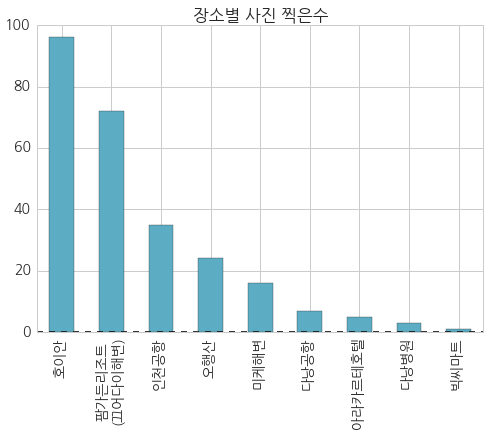

In [22]:
place_pictures_ds = image_meta_ds.groupby(['place']).count()[['datetime']].sort(['datetime'], ascending=False)

place_pictures_ds.plot(kind='bar', legend=False, color='#5CACC4')
plt.title('장소별 사진 찍은수')
plt.xlabel('')
plt.show()



## 가장 많이 찍은 두 지역에서 가장 밝게 웃고 있는 사진은?

## 언제 사진을 많이 찍었는가?

날짜별로 호이안과 팜가든리조트 일정이 있었던 4/21,4/22일 가장을 가장 많이 찍었고, 

와이프가 항공 중이염으로 아팠던 4/20은 여행의 본격 시작 됐음에도 사진을 적게 찍었음을 알수 있었다. 


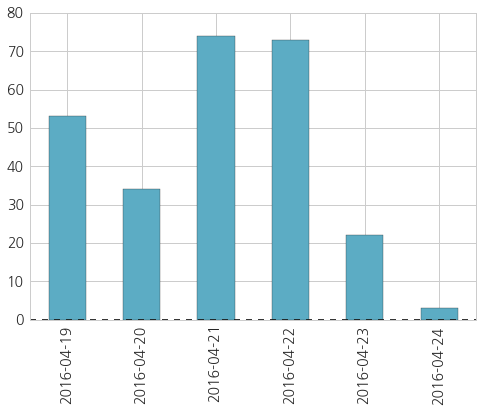

In [23]:
image_meta_ds.groupby(['ymd']).count()[['datetime']].plot(kind='bar', legend=False, color='#5CACC4')
plt.xlabel('')
plt.show()

In [26]:
## 이동경로 인덱스를 생성한다. 
route_idx = []
old = ''
current_idx = 0
for idx, row in image_meta_ds.iterrows():
    if old != row.place:
        old = row.place
        current_idx += 1
    route_idx.append(current_idx)  
image_meta_ds['route_idx'] = route_idx

In [28]:
image_meta_ds.head(2)

,index,datetime,place,latitude,place_idx,longitude,me_age,junior_age,wife_smiling,junior_smiling,me_smiling,person,wife_age,hourofyear,ymd,image_idx,imagepath,smiling,age,route_idx
0,IMG_1404.JPG,2016-04-19 07:43:35,인천공항,37.361,0,127.101814,25,0,0,0,10.9236,1,0,3103,2016-04-19,1404,./resource/image/IMG_1404.JPG,10.9236,25,1
1,IMG_1405.JPG,2016-04-19 07:43:35,인천공항,37.361,0,127.101814,27,0,0,0,49.7110,1,0,3103,2016-04-19,1405,./resource/image/IMG_1405.JPG,49.7110,27,1


In [29]:
route_grouped = image_meta_ds.groupby(['route_idx','place','place_idx'])
route_infos = []
for route,group in route_grouped:
    route_infos.append( [route[0], route[1], route[2], group.shape[0], group.smiling.max(), 
                         group.datetime.min() + (group.datetime.max()-group.datetime.min())/2,
                        group.datetime.max()-group.datetime.min()] )
    
trip_route_ds = pd.DataFrame(route_infos, 
                    columns=['seq','place', 'place_no', 'picture_cnt','smiling-max', 'timestamp', 'duration'])

In [30]:
trip_route_ds.fillna(0, inplace=True)

In [31]:
## X bar list 
trip_list = {}
cur_pos = 10
for (idx, row) in trip_route_ds.iterrows():
    if row.place_no not in trip_list:
        trip_list[row.place_no] = []
    trip_list[row.place_no].append((cur_pos, row.picture_cnt+5))
    cur_pos += (row.picture_cnt+5)+3
# Y label data
y_ticks = []
y_label = []
for (idx,label) in enumerate(base_loc_pos):
    y_ticks.append(15+idx*10)
    y_label.append(label[0])
    
y_label

['인천공항',
 '다낭공항',
 '아라카르테호텔',
 '다낭병원',
 '빅씨마트',
 '미케해변',
 '오행산',
 '호이안',
 '팜가든리조트\n(끄어다이해변)']

## 우리의 여행 이동 경로는?

우리의 큰일정은 다음과 같았다. 
> 인천공항 --> 아라카르트 호텔(2박)+ 다낭시내 --> 팜가든리조트(2박) + 호이안 --> 인천공항 

실제 사진의 시간순으로 여행 이동경로를 보자 

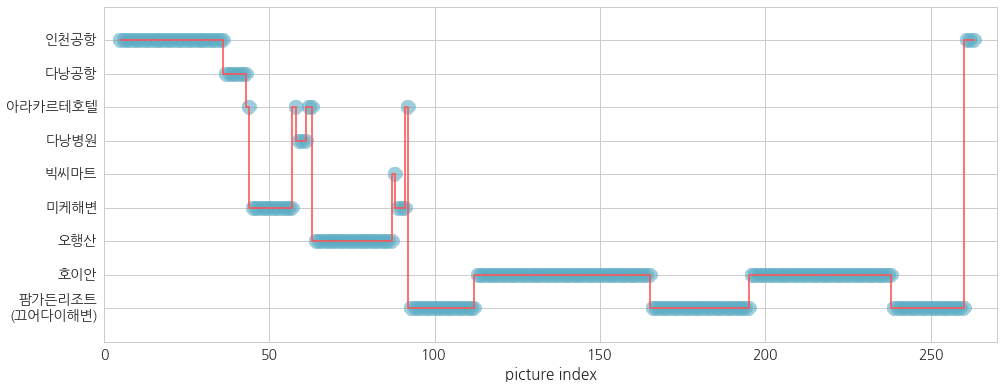

In [32]:
fig, ax = plt.subplots()
ax.plot([idx+5 for idx in image_meta_ds.index.tolist()], (10 - image_meta_ds.place_idx).tolist(),
        'o',ms=15, alpha=0.6 , drawstyle='steps', color='#5CACC4')
ax.plot([idx+5 for idx in image_meta_ds.index.tolist()], (10 - image_meta_ds.place_idx).tolist(),
        '-',ms=15,linewidth=2,  alpha=0.8 , drawstyle='steps', color='#FF5254')
ax.set_ylim(1,11)
ax.set_xlim(0,270)
plt.xlabel('picture index')
ax.set_yticks([ tick/10+0.5 for tick in y_ticks])
ax.set_yticklabels(y_label[::-1])

fig.set_figwidth(16)
fig.set_figheight(6)

fig.set_gid(False) 

## 이미지 분석 API로 얼마나 웃고 나이들어 보이는지 알아 보자 

요즘 deep learning 발달로 이미지 분석 기술이 좋아 졌다. 그리고 좋은 기술들은 손쉽게 사용할 수 있도록 API를 제공해 주는데 
나는 face plusplus에서 제공해 주는 face 분석 API를 통해 사진의 웃는 정도(smiling)와 나이(age) 분석값으로 
내가 여행중 얼마나 웃고 즐기는지를 측정해 보고자 한다. 

<img src='./resource/screen-facepp.png'/>

In [33]:
image_meta_ds.head(3).T

,0,1,2
index,IMG_1404.JPG,IMG_1405.JPG,IMG_1406.JPG
datetime,2016-04-19 07:43:35,2016-04-19 07:43:35,2016-04-19 07:43:40
place,인천공항,인천공항,인천공항
latitude,37.361,37.361,37.361
place_idx,0,0,0
longitude,127.1018,127.1018,127.1018
me_age,25,27,43
junior_age,0,0,0
wife_smiling,0,0,0
junior_smiling,0,0,0


## 누가 가장 잘 웃고, 나이들어 보이나

누가누가 잘웃나?

wife의 웃음지수가 평균 60 이다. 원래 평소에는 내가 잘 웃는것으로 알고 있는데 의외로 wife의 웃음 지수가 높다. 


In [34]:
def getMean(target):
    return round(image_meta_ds[image_meta_ds[target]>0][target].mean(),2)

print( "평균 웃음지수 : ", getMean('smiling') )
print( "Me 웃음지수 = ", getMean('me_smiling') )
print( "Wife 웃음지수 = ", getMean('wife_smiling') )
print( "Junior 웃음지수 = ", getMean('junior_smiling') )
   

평균 웃음지수 :  39.85
Me 웃음지수 =  40.92
Wife 웃음지수 =  60.54
Junior 웃음지수 =  9.43


In [35]:
def mostSimilingByPeople(target, top=3, order = False):
    tmp_ds = image_meta_ds[(image_meta_ds[target] > 0 )].sort([target], ascending=order)
    drawImages(tmp_ds.imagepath[:top].values)
    print("   \t\t".join( tmp_ds[target].apply(lambda x: str(round(x,2))).values[:3]))
    
print( "**Me 평균 웃음지수 = ", getMean('me_smiling') )
mostSimilingByPeople('me_smiling')
print( "\n**wife 평균 웃음지수 = ", getMean('wife_smiling') )
mostSimilingByPeople('wife_smiling')
print( "\n**junior 평균 웃음지수 = ", getMean('junior_smiling') )
mostSimilingByPeople('junior_smiling')

**Me 평균 웃음지수 =  40.92


93.34   		90.76   		89.47

**wife 평균 웃음지수 =  60.54


99.58   		99.0   		98.41

**junior 평균 웃음지수 =  9.43


78.16   		72.07   		38.45


In [36]:
print( "**Me 평균 웃음지수 = ", getMean('me_smiling') )
mostSimilingByPeople('me_smiling', order=True)
print( "\n**wife 평균 웃음지수 = ", getMean('wife_smiling') )
mostSimilingByPeople('wife_smiling', order=True)
print( "\n**junior 평균 웃음지수 = ", getMean('junior_smiling') )
mostSimilingByPeople('junior_smiling', order=True)

**Me 평균 웃음지수 =  40.92


1.58   		3.25   		6.27

**wife 평균 웃음지수 =  60.54


1.33   		3.38   		4.44

**junior 평균 웃음지수 =  9.43


0.21   		0.36   		0.42


## 언제 가장 많이 웃었는가?


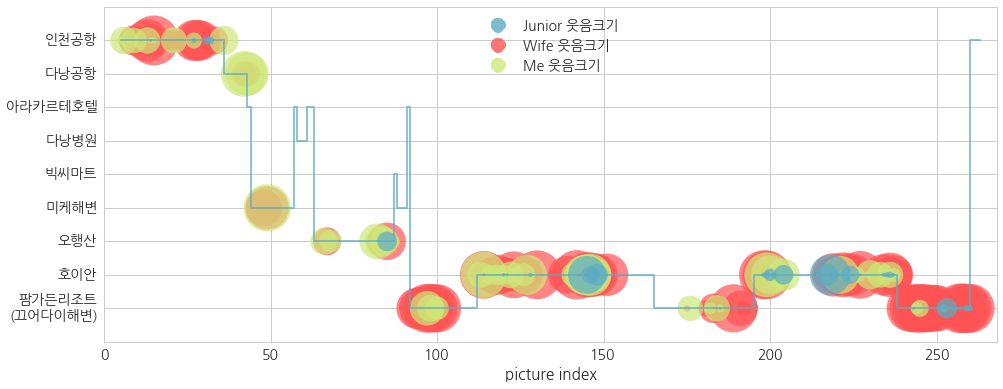

In [37]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

draw_ds = image_meta_ds
fig, ax = plt.subplots()

## draw path line
ax.plot([idx+5 for idx in draw_ds.index.tolist()], (10 - draw_ds.place_idx).tolist(),
        '-', linewidth=2,  ms=15, alpha=0.7 , drawstyle='steps', color='#5CACC4')

cmap = { 'Me':'#CEE879', 'Wife':'#FF5254', 'Junior':'#5CACC4' }
## draw smiling index 
ax.scatter( [idx+5 for idx in draw_ds.index.tolist()], (10 - draw_ds.place_idx).tolist()
           , linewidth=0, c=cmap['Wife'], s=(draw_ds.wife_smiling.fillna(0)**1.7).tolist(), alpha=0.7
          )
ax.scatter( [idx+5 for idx in draw_ds.index.tolist()], (10 - draw_ds.place_idx).tolist()
           , linewidth=0, c=cmap['Me'], s=(draw_ds.me_smiling.fillna(0)**1.7).tolist(), alpha=0.7
          )
ax.scatter( [idx+5 for idx in draw_ds.index.tolist()], (10 - draw_ds.place_idx).tolist()
           , linewidth=0, c=cmap['Junior'], s=(draw_ds.junior_smiling.fillna(0)**1.7).tolist(), alpha=0.7
          )


ax.set_ylim(1,11)
ax.set_xlim(0,draw_ds.index.max()+10)
plt.xlabel('picture index')
ax.set_yticks([ tick/10+0.5 for tick in y_ticks])
ax.set_yticklabels(y_label[::-1])

legend_list = []
for (nm, c) in cmap.items():
    legend_list.append(mlines.Line2D([], [], color=c, marker='o',markersize=15, label=nm+' 웃음크기', linewidth=0, alpha=0.8))
plt.legend(handles=legend_list, loc='upper center')


fig.set_figwidth(16)
fig.set_figheight(6)

## 사진속 나이는 ?


In [38]:
def getMean(target):
    return round(image_meta_ds[image_meta_ds[target]>0][target].mean(),2)

print( "me age = ", getMean('me_age') )
print( "wife age = ", getMean('wife_age') )
print( "junior age = ", getMean('junior_age') )

me age =  36.3
wife age =  29.58
junior age =  2.82


## 가장 나이들어 보일때는 

In [39]:
def mostAntiAgingByPeople(target, top=3, order=False):
    tmp_ds = image_meta_ds[(image_meta_ds[target] > 0 )].sort([target], ascending=order)
    drawImages(tmp_ds.imagepath[:top].values)
    
    
    print("   \t\t".join( tmp_ds[target].apply(lambda x: ("%d세" % (round(x))).rjust(5)).values[:3]))
    
    
print( "**Me 평균 예측나이 = %.2f세 (실제 39세)" % getMean('me_age') )
mostAntiAgingByPeople('me_age')
print( "\n**wife 평균 예측나이 = %.2f세 (실제 39세)" %  getMean('wife_age') )
mostAntiAgingByPeople('wife_age')
print( "\n**junior 평균 예측나이 = %.2f세 (실제 4세)" %  getMean('junior_age') )
mostAntiAgingByPeople('junior_age')

**Me 평균 예측나이 = 36.30세 (실제 39세)


  55세   		  54세   		  54세

**wife 평균 예측나이 = 29.58세 (실제 39세)


  61세   		  59세   		  50세

**junior 평균 예측나이 = 2.82세 (실제 4세)


   9세   		   8세   		   7세


## 가장 젊어 보이는 사진은 ?

In [40]:
print( "**Me 평균 예측나이 = %.2f세 (실제 39세)" % getMean('me_age') )
mostAntiAgingByPeople('me_age', order=True)
print( "\n**wife 평균 예측나이 = %.2f세 (실제 39세)" %  getMean('wife_age') )
mostAntiAgingByPeople('wife_age', order=True)
print( "\n**junior 평균 예측나이 = %.2f세 (실제 4세)" %  getMean('junior_age') )
mostAntiAgingByPeople('junior_age', order=True)

**Me 평균 예측나이 = 36.30세 (실제 39세)


  19세   		  20세   		  22세

**wife 평균 예측나이 = 29.58세 (실제 39세)


  12세   		  13세   		  14세

**junior 평균 예측나이 = 2.82세 (실제 4세)


   1세   		   1세   		   1세


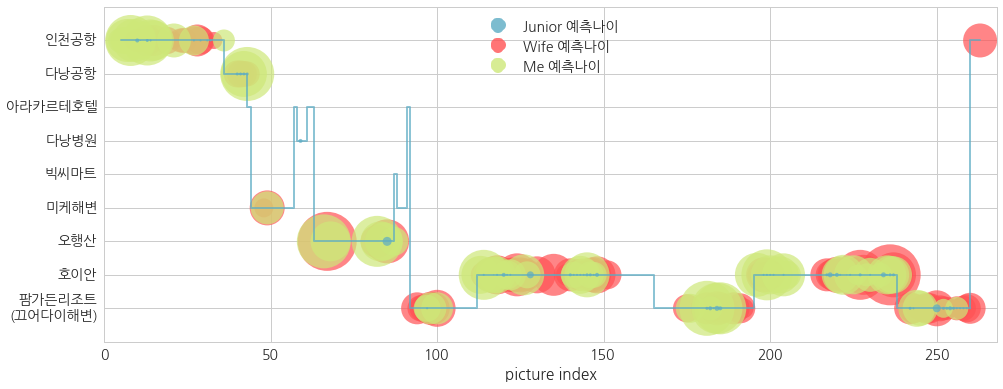

In [41]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

draw_ds = image_meta_ds
fig, ax = plt.subplots()

## draw path line
ax.plot([idx+5 for idx in draw_ds.index.tolist()], (10 - draw_ds.place_idx).tolist(),
        '-', linewidth=2,  ms=15, alpha=0.7 , drawstyle='steps', color='#5CACC4')

cmap = { 'Me':'#CEE879', 'Wife':'#FF5254', 'Junior':'#5CACC4' }
## draw smiling index 
ax.scatter( [idx+5 for idx in draw_ds.index.tolist()], (10 - draw_ds.place_idx).tolist()
           , linewidth=0, c=cmap['Wife'], s=(draw_ds.wife_age.fillna(0)**2).tolist(), alpha=0.7
          )
ax.scatter( [idx+5 for idx in draw_ds.index.tolist()], (10 - draw_ds.place_idx).tolist()
           , linewidth=0, c=cmap['Me'], s=(draw_ds.me_age.fillna(0)**2).tolist(), alpha=0.7
          )
ax.scatter( [idx+5 for idx in draw_ds.index.tolist()], (10 - draw_ds.place_idx).tolist()
           , linewidth=0, c=cmap['Junior'], s=(draw_ds.junior_age.fillna(0)**2).tolist(), alpha=0.7
          )


ax.set_ylim(1,11)
ax.set_xlim(0,draw_ds.index.max()+10)
plt.xlabel('picture index')
ax.set_yticks([ tick/10+0.5 for tick in y_ticks])
ax.set_yticklabels(y_label[::-1])

legend_list = []
for (nm, c) in cmap.items():
    legend_list.append(mlines.Line2D([], [], color=c, marker='o',markersize=15, label=nm+' 예측나이', linewidth=0, alpha=0.8))
plt.legend(handles=legend_list, loc='upper center')


fig.set_figwidth(16)
fig.set_figheight(6)

In [42]:
## 타입 테이블 만들기
image_meta_ds['hour'] = image_meta_ds.datetime.apply(lambda x: x.strftime('%H H'))
image_meta_ds['day'] = image_meta_ds.datetime.apply(lambda x: x.strftime('%m-%d'))


###  지역 날짜별 평균 웃음 지수 

In [43]:
import seaborn as sns
def drawHitTable(ds, title):
    sns.set(style="whitegrid", palette="pastel", color_codes=True, font_scale=1.4)
    rcParams['font.family'] = 'NanumGothic'
    plt.figure(figsize=(10,8))
    sns.heatmap(ds, annot=True, linewidths=.5)
    plt.title(title)
    plt.xlabel('')
    plt.ylabel('')
    plt.show()

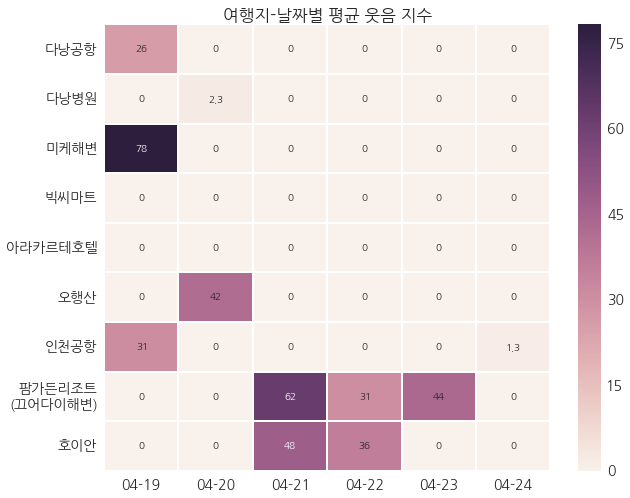

In [44]:
timetable = image_meta_ds.pivot_table(values='smiling', index='place', columns='day').fillna(0)

drawHitTable(timetable, '여행지-날짜별 평균 웃음 지수')

### 지역 날짜별 평균 예측 나이 

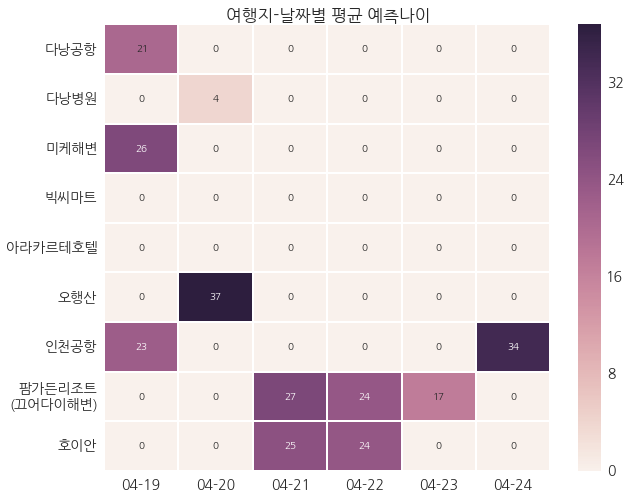

In [45]:
timetable = image_meta_ds.pivot_table(values='age', index='place', columns='day').fillna(0)

drawHitTable(timetable, '여행지-날짜별 평균 예측나이')

### 오행상 돌산 사진들 

In [46]:
drawImages(image_meta_ds[image_meta_ds.place=='오행산'].sort('age', ascending=True)[::2]['imagepath'].values, size='150px')


In [47]:
## 인식 안된 사진들
image_meta_ds = image_meta_ds.fillna(0)
drawImages(image_meta_ds[image_meta_ds.person==0].sort('age', ascending=True)[1::3]['imagepath'].values)

In [48]:
## 잘웃지 않는 사진 
drawImages(image_meta_ds[image_meta_ds.age>0].sort('age', ascending=True)[::3]['imagepath'].values)

In [51]:
## 나이 어린 사진
drawImages(image_meta_ds[image_meta_ds.age>0].sort('age', ascending=True)[:12]['imagepath'].values)

In [52]:
## 잘웃지 않는 사진 
drawImages(image_meta_ds[image_meta_ds.age>0].sort('age', ascending=False)[:10]['imagepath'].values)